<a href="https://colab.research.google.com/github/gkdivya/MLAssignment/blob/main/PersonCar_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Person Car Detection 

In this notebook, we will use dataset present in: https://evp-ml-data.s3.us-east-2.amazonaws.com/mlinterview/openimages-personcar/trainval.tar.gz
to train a model to localize and classify each instance of person and car in images.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [14]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-7ky2140l
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-7ky2140l
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263921 sha256=a2dd8559899e18530899187455dcef63f93d665bacc4736abd11d49399fb0082
  Stored in directory: /tmp/pip-ephem-wheel-cache-dpqvx0re/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


## Defining the Dataset

Custom dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible.



### Writing a custom dataset for Person-Car dataset

Extracted from the below path
https://evp-ml-data.s3.us-east-2.amazonaws.com/mlinterview/openimages-personcar/trainval.tar.gz

In [15]:
# download the dataset
#wget http://evp-ml-data.s3.us-east-2.amazonaws.com/mlinterview/openimages-personcar/trainval.tar.gz


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!tar -xf  '/content/drive/MyDrive/MLAssignmentDS/trainval.tar.gz'

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
trainval/
  images/
    image_000000001.jpg
    image_000000001.jpg
    image_000000001.jpg
    image_000000001.jpg
    ...
  annotations/
    bbox-annotations.json
```

Here is one example of an image in the dataset:

      "category_id": 1,
      "image_id": 0,
      "segmentation": [],
      "iscrowd": 0,
      "bbox": [
        846,
        145,
        146,
        477
      ],

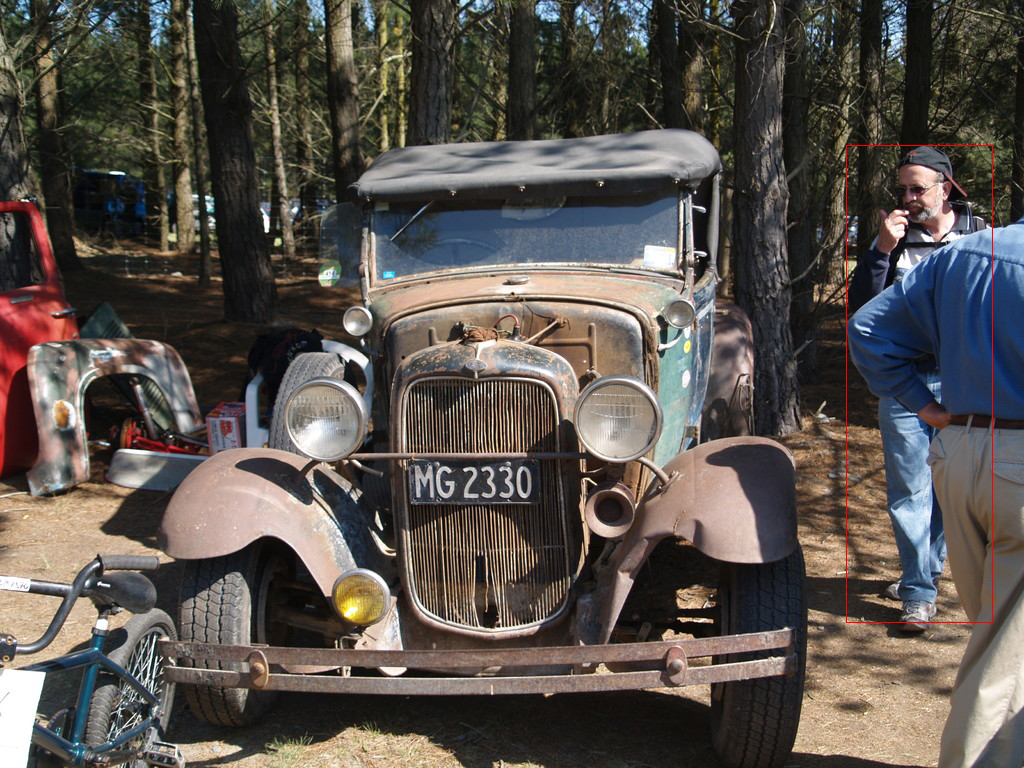

In [18]:
from PIL import Image, ImageDraw
img = Image.open('/content/trainval/images/image_000000001.jpg')
draw = ImageDraw.Draw(img)
shape = [(846, 145), (846 + 146, 145 + 477)] #Sample annotation of person

draw.rectangle(shape, outline ="red")
img.show()
img

In [47]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class PersonCarDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]

            if(((xmax-xmin) <= 0) or ((ymax-ymin) <= 0)):
              print(f'Negative values for width and height for image: {img_id}')
            else:
              boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        data_annotation = {}
        data_annotation["boxes"] = boxes
        data_annotation["labels"] = labels
        data_annotation["image_id"] = img_id
        data_annotation["area"] = areas
        data_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, data_annotation

    def __len__(self):
        return len(self.ids)

### Data Augmentation/Transformation


In [48]:
def get_transform(train=True):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    # Not adding mean/std normalization nor image rescaling in the data transforms, 
    # as those are handled internally by the Mask R-CNN model
    transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(transforms)

# path to your own data and coco file
train_data_dir = '/content/trainval/images'
train_coco = '/content/trainval/annotations/bbox-annotations.json'

# create own Dataset
person_car_dataset = PersonCarDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [49]:
# Batch size
train_batch_size = 1

# own DataLoader
data_loader = torch.utils.data.DataLoader(person_car_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(imgs)
    print(annotations)
    print(len(imgs))
    print(len(annotations))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[tensor([[[0.2902, 0.2784, 0.2824,  ..., 0.9961, 0.9961, 0.9961],
         [0.2784, 0.3020, 0.2941,  ..., 0.9961, 0.9961, 0.9961],
         [0.2863, 0.2784, 0.2824,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.3804, 0.3922, 0.3961,  ..., 0.7373, 0.7216, 0.7412],
         [0.4078, 0.4039, 0.4078,  ..., 0.7255, 0.7176, 0.7373],
         [0.3961, 0.3686, 0.3529,  ..., 0.7216, 0.7176, 0.7333]],

        [[0.4039, 0.3922, 0.3961,  ..., 0.9961, 0.9961, 0.9961],
         [0.3922, 0.4157, 0.4078,  ..., 0.9961, 0.9961, 0.9961],
         [0.4000, 0.3922, 0.3961,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.3804, 0.4000, 0.4039,  ..., 0.7412, 0.7333, 0.7451],
         [0.4039, 0.4118, 0.4157,  ..., 0.7373, 0.7294, 0.7412],
         [0.3922, 0.3765, 0.3608,  ..., 0.7333, 0.7294, 0.7373]],

        [[0.4353, 0.4235, 0.4275,  ..., 0.9961, 0.9961, 0.9961],
         [0.4235, 0.4471, 0.4392,  ..., 0.9961, 0.9961, 0.9961],
         [0.4314, 0.4235, 0.4275,  ..., 0.9961, 0.9961, 0

That's all for the dataset. Let's see how the outputs are structured for this dataset

The dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes` and `labels`.

## Defining model

Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

We want to start from a pre-trained model, and just finetune the last layer for predicting person and car.

### 1 - Finetuning from a pretrained model

Let's start from a model pre-trained on COCO and finetune it for person and car classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + 2 (car)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

In [50]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    

# 2 classes; Only target class or background
num_classes = 2
num_epochs = 10
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Streaming output truncated to the last 5000 lines.
Iteration: 1727/2239, Loss: 0.27812761068344116
Iteration: 1728/2239, Loss: 1.0291742086410522
Iteration: 1729/2239, Loss: 0.37652814388275146
Iteration: 1730/2239, Loss: 0.8547356128692627
Iteration: 1731/2239, Loss: 0.28929319977760315
Iteration: 1732/2239, Loss: 0.09834475815296173
Iteration: 1733/2239, Loss: 0.46177029609680176
Iteration: 1734/2239, Loss: 0.5755889415740967
Iteration: 1735/2239, Loss: 0.7333644032478333
Iteration: 1736/2239, Loss: 0.33954745531082153
Iteration: 1737/2239, Loss: 0.916802167892456
Iteration: 1738/2239, Loss: 0.9282150864601135
Iteration: 1739/2239, Loss: 0.834670901298523
Iteration: 1740/2239, Loss: 1.0084460973739624
Iteration: 1741/2239, Loss: 0.19974015653133392
Iteration: 1742/2239, Loss: 0.6103761196136475
Iteration: 1743/2239, Loss: 0.7735859751701355
Iteration: 1744/2239, Loss: 0.22049842774868011
Iteration: 1745/2239, Loss: 0.49067431688308716
Iteration: 1746/2239, Loss: 1.5369837284088135
It

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 25495, done.
remote: Counting objects: 100% (2965/2965), done.
remote: Compressing objects: 100% (785/785), done.
remote: Total 25495 (delta 2209), reused 2790 (delta 2124), pack-reused 22530
Receiving objects: 100% (25495/25495), 34.57 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (18902/18902), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [57]:
#print(person_car_dataset[0])
# pick one image from the test set
img = person_car_dataset[0][0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [58]:
prediction

[{'boxes': tensor([[ 837.6614,  142.1980, 1015.8918,  648.0716],
          [  56.1392,  137.4880,  809.2854,  766.6158],
          [   5.5959,  559.7585,  188.3082,  764.8265],
          [ 587.5227,  411.5381,  807.8237,  724.7328],
          [   0.0000,  187.5390,   85.2783,  494.8506],
          [ 696.6387,  294.2428,  764.5112,  448.3188],
          [  12.6463,  422.2875,  449.4859,  751.4888],
          [  62.8187,  563.7043,  176.4329,  703.7015],
          [   4.1533,  209.7648,  155.5439,  496.5789],
          [ 865.1324,  205.5098,  954.2268,  634.2938],
          [  84.2612,  164.7783,  142.8866,  244.0580],
          [ 678.3524,  248.1554,  717.9630,  312.8332],
          [ 679.3672,  248.0713,  715.8928,  392.4801],
          [ 841.5938,  215.0720,  861.4454,  257.9598],
          [ 292.2397,  267.7117,  663.1541,  656.6176],
          [ 297.5090,  327.2878,  834.6724,  750.2018],
          [ 234.1851,  327.4695,  369.1465,  474.5247],
          [ 976.0016,  213.3338,  998.2

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

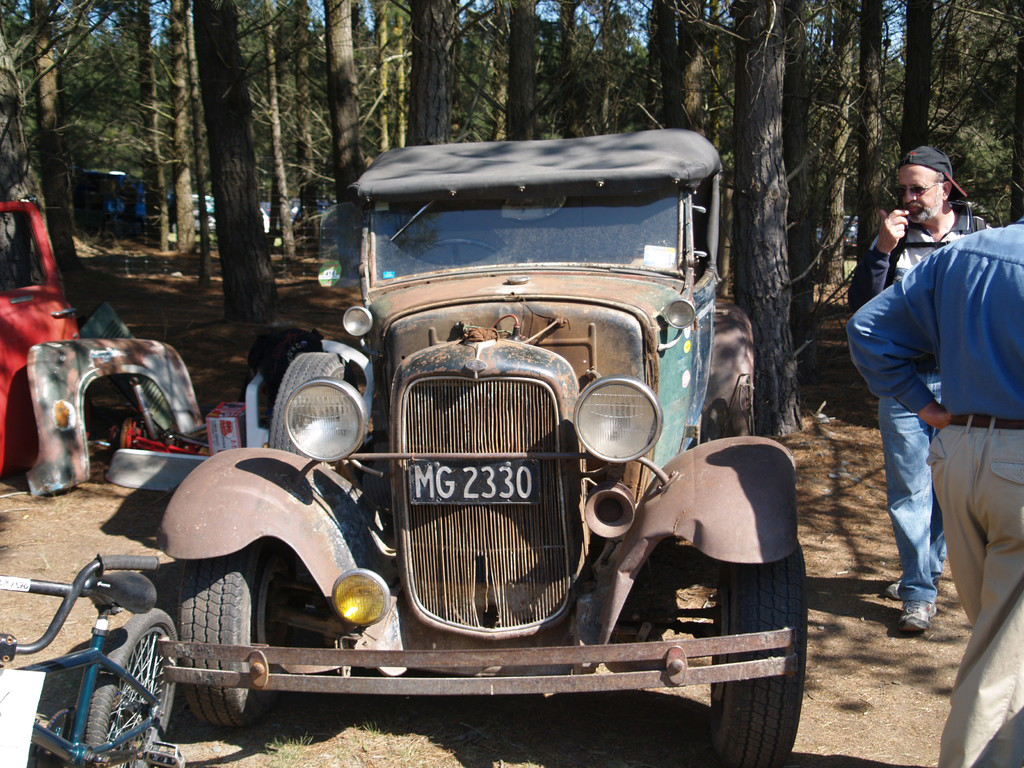

In [59]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [64]:
import numpy as np

# If the box classification value is less than this, we ignore this box
score_threshold = 0.7

image_outputs = []

boxes = prediction[0]['boxes'].data.cpu().numpy()
scores = prediction[0]['scores'].data.cpu().numpy()

mask = scores >= score_threshold
boxes = boxes[mask].astype(np.int32)
scores = scores[mask]
image_outputs.append((boxes, scores))

In [65]:
image_outputs

[(array([[ 837,  142, 1015,  648],
         [  56,  137,  809,  766]], dtype=int32),
  array([0.9869069, 0.930774 ], dtype=float32))]

[[ 837  142 1015  648]
 [  56  137  809  766]]


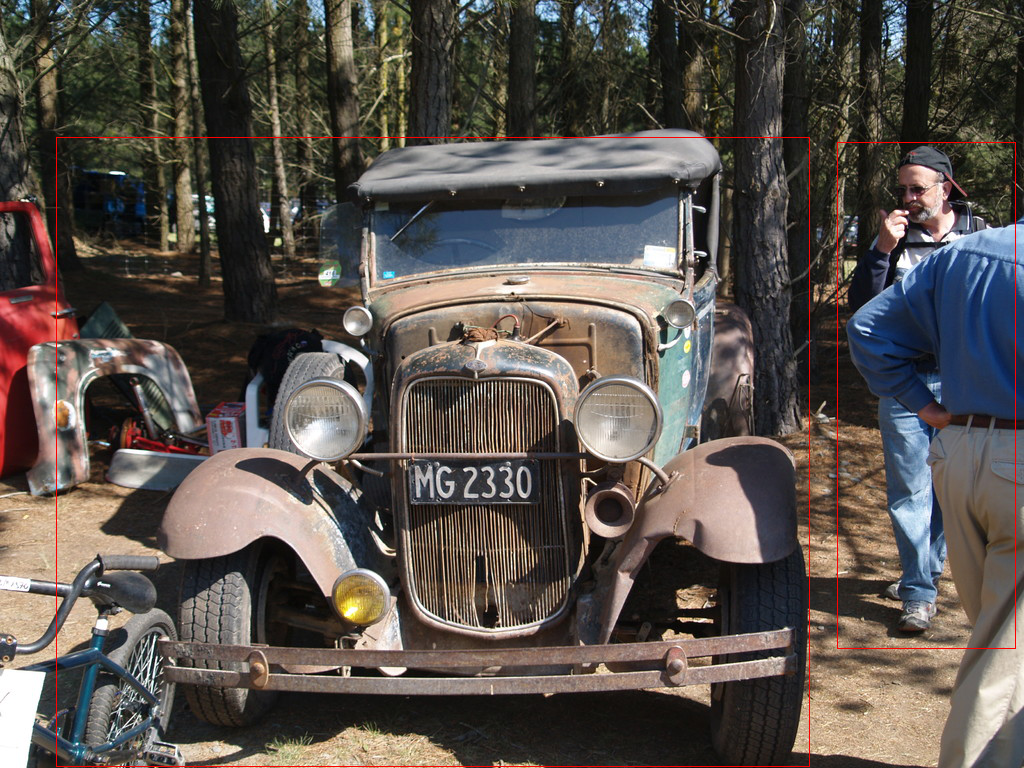

In [68]:
boxes, scores = image_outputs[0]
print(boxes)

#img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(img)
for box in boxes:
  shape = [box[0], box[1], box[2], box[3]] #Sample annotation of person
  draw.rectangle(shape, outline ="red")
img.show()
img
